In [153]:
import numpy as np
import os
import glob
import shutil
import matplotlib.pyplot as plt
import json
import subprocess
import scipy.interpolate as interp
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from IPython.display import Image
%matplotlib inline

Module for computations (if needed)

In [154]:
import FEM_utilities as FEM

# Lab 06

## 2) Buckling and post-buckling of a cantilever

## Write input file - Beam

In [155]:
def write_beam_inp_file(L, h, b, num_e, E, ν, num_modes, typ='B', inc=1000, Lpb = 1, t_data=None):
    """
    function to write inp file:
    L        : lenght of cantilever
    h        : height
    b        :  thickness
    num_e    : number of elements
    E        : Young's modulus
    nu       : Poisson ratio
    num_modes: number of eigenvalues to be estimated
    typ      : type of analysis
                B (default) = buckling
                P = postbuckling without imperfection
                I = postbuckling with imperfection
    inc      : number of steps for nonlinear postbuckling analysis
    Lpb      : load for postbuckling (should be about 10*Pcr)
    t_data   : parameters for step increment
    """
    
    if typ == 'I':
        basename = 'b4_ne'+str(num_e).zfill(3)+'_aB'
        impbasename = 'b2_ne'+str(num_e).zfill(3)+'_aB'
    elif typ == 'P':
        basename = 'b3_ne'+str(num_e).zfill(3)+'_aB'
    else:
        basename = 'b2_ne'+str(num_e).zfill(3)+'_aB'
    
    filename = basename+'.inp'
    
    outfile = open(filename, "wt")
    
    if typ == 'I':
        outfile.write("** Lab 06 input file postbuckling - imperfection\n")
    elif typ == 'P':
        outfile.write("** Lab 06 input file postbuckling - std\n")
    else:
        outfile.write("** Lab 06 input file buckling - beam\n")
    
    elname = "EALL"
    matname = "mat1"
    buckstep = "buckling"
    
    n_coords = np.zeros((num_e+1,2))
    
    for ni in range(1,num_e+1):
        n_coords[ni,0] = ni/(num_e)*L
        
    # NODES section
    outfile.write("**\n")
    outfile.write("** Nodes\n")
    outfile.write("**\n")
    outfile.write("*NODE\n")
    
    for i in range(num_e+1):
        nodestring = "{0:4d},{1:8},{2:8}\n".format(i+1,n_coords[i,0],n_coords[i,1])
        outfile.write(nodestring)
    
    # imperfection
    if typ == 'I':
        outfile.write("*IMPERFECTION, file={0} ,step={1}\n".format(impbasename,1))
        outfile.write("{0},{1}\n".format(1,.05))
        
    # ELEMENTS section
    outfile.write("**\n")
    outfile.write("** Elements\n")
    outfile.write("**\n")
    outfile.write("*ELEMENT, TYPE={0}, ELSET={1}\n".format('B31',elname))
    for i in range(1,num_e+1):
        outfile.write("{0:4d},{1:4d},{2:4d}\n".format(i,i,i+1))
    
    # BEAM section
        
    outfile.write("**\n")
    outfile.write("** Beam section\n")
    outfile.write("**\n")
    outfile.write("*BEAM SECTION, SECTION=RECT, MATERIAL={0}, ELSET={1}\n".format(matname,elname))
    outfile.write("{0},{1}\n".format(b,h))
    # default orientation?
    outfile.write("0,0,-1\n")
    
    # MATERIAL section
    outfile.write("**\n")
    outfile.write("** Materials\n")
    outfile.write("**\n")
    outfile.write("*MATERIAL, name = {0}\n".format(matname))
    outfile.write("*ELASTIC\n")
    outfile.write("{0},{1:6}\n".format(E,ν))
    
    
    # BOUNDARY CONDITIONS
    outfile.write("**\n")
    outfile.write("** Boundary conditions\n")
    outfile.write("**\n")
    outfile.write("*BOUNDARY\n")
    outfile.write("1,\t1,\t6\n")
    
    # calculation steps
    
    outfile.write("**\n")
    outfile.write("** Step\n")
    outfile.write("**\n")
    
    
    if typ == 'P' or typ == 'I':
        outfile.write("*STEP, NLGEOM, INC={0}\n".format(inc))
        outfile.write("*STATIC, RIKS\n")
        
        """
        outfile.write("{0},{1},{2},{3},{4},{5},{6},{7}\n".format(t_data[0], \
                      t_data[1], t_data[2], t_data[3], t_data[4], t_data[5], t_data[6], \
                      t_data[7]))        
        """
        outfile.write("{0},,,,{4},{5},{6},{7}\n".format(t_data[0], \
                      t_data[1], t_data[2], t_data[3], t_data[4], t_data[5], t_data[6], \
                      t_data[7]))        

    else:
        outfile.write("*STEP, name = {0}\n".format(buckstep))
        outfile.write("*BUCKLE\n")
        outfile.write("{0},\n".format(num_modes))
    
    # LOADS
    
    outfile.write("**\n")
    outfile.write("** Loads\n")
    outfile.write("**\n")
    outfile.write("*Cload\n")
    if typ == 'P' or  typ == 'I':
        outfile.write("{0}, {1:2d}, {2:.3f}\n".format(num_e+1, 1, -np.abs(Lpb) ))
    else:
        outfile.write("{0}, {1:2d}, {2}\n".format(num_e+1, 1, -1. ))
    
    if typ == 'P' or typ == 'I':
        #outfile.write("*OUTPUT,FIELD\n")
        #outfile.write("*ELEMENT OUTPUT\n")
        #outfile.write("S,COORD,\n")
        #outfile.write("*EL PRINT\n")
        #outfile.write(" S,COORD,\n")
        outfile.write("*OUTPUT,FIELD\n")
        outfile.write("*NODE OUTPUT\n")
        outfile.write("U,COORD\n")
        outfile.write("*NODE PRINT\n")
        outfile.write("U,COORD\n")
        outfile.write("*OUTPUT,HISTORY,FREQUENCY={0}\n".format(inc))
    else:
        outfile.write("*NODE FILE, GLOBAL=YES, LAST MODE={0}\n".format(num_modes))
        outfile.write("U,\n")
    #outfile.write("*EL FILE, ELSET=PRINT, LAST MODE={0}\n".format(num_modes))
    #outfile.write("ENER,\n")
    #outfile.write("ELEN,\n")
    outfile.write("*END STEP\n")

    outfile.close()
    
    if not os.path.exists('../Lab06b_abaqus/'+basename+'/'):
        os.makedirs('../Lab06b_abaqus/'+basename+'/')

    shutil.move(filename,'../Lab06b_abaqus/'+basename+'/'+filename)
    
    if typ == 'I':
        shutil.copy('../Lab06b_abaqus/'+impbasename+'/'+impbasename+'.fil', \
                    '../Lab06b_abaqus/'+basename+'/'+impbasename+'.fil')

Set parameters for simulation:

- *L, b, h* : cantilever dimensions
- *eig_num* : maximum eigenvalue to be estimated
- **E**, $\nu$: elastic properties (Young modulus and Poisson ratio, as *TYPE* is by default **isotropic**)
- *num_elems*: number of elements in **x** direction

In [156]:
L = 200. # lenght [mm]
h = 15.  # height [mm]
b = 1.5  # thickness [mm]


eig_num = 10

E = 72000. # modulus [MPa]
ν = 0.33   # Poisson's coefficient

# number of elements

#num_elems = [1, 2, 4, 5, 10, 20, 25, 50, 100, 200]
num_elems = [2, 5, 10, 25, 50, 100]

for ne in num_elems:
    write_beam_inp_file(L, h, b, ne, E, ν, eig_num)

In [157]:
def generateCases(loc, prefix):
    """
    generates all cases from specified root directory and starting with prefix
    loc : root directory
    """
    curr_dir = os.getcwd()
    
    if not loc.startswith("/"):
        #relativer path
        base_dir = os.path.abspath(loc)
    else:
        base_dir = loc
    
    #print(curr_dir)
    dirs = glob.glob(loc+"/"+prefix+"*")
    
    command = ['/usr/simulia/abaqus/Commands/abaqus']
    
    options = [['datacheck','interactive'],['interactive','continue']]
    
    for di in dirs:
        test = di.split('/')[-1]
        os.chdir(di)
        job="j={0}".format(test)
        
        for opt in options:
            subprocess.call(command+[job]+opt)
        
        os.chdir(base_dir)
        
    os.chdir(curr_dir)

# Generate Abaqus cases

In [158]:
generateCases("../Lab06b_abaqus/","b2_")

# Analytical solution:

$P_{cr}$ analytical relation:

$P_{cr} = k^2 \cdot \frac{ \pi^2 E I_{22}}{l_i^2}$

where:
- $k = 1 \dotsc n$
- $I_{22} = \frac{1}{12} \cdot hb^3$
- $l_i = 2 \cdot l$ for cantilever

In [159]:
eig_num_search = 5

I22 = h*b**3/12

Pcr = np.zeros(eig_num_search)

for i in range(eig_num_search):
    Pcr[i] = ((2*i+1)**2)/((2*L)**2)*(np.pi**2)*E*I22
    
    
    
print("Pcr = ")

for i in range(eig_num_search):
    print("{0:2d} | {1:.3f}".format(i+1,Pcr[i]))


Pcr = 
 1 | 18.737
 2 | 168.631
 3 | 468.421
 4 | 918.105
 5 | 1517.683


# Simulations data

In [160]:
def readDataL06b(filename, num):
    
    file=open(filename,'r') 
    row = file.readlines()
    
    eig = np.ones(num)
    
    state = 0
    
    for line in row:
        strlist = line.split()
        if state == 0 and 'MODE' in strlist and 'NO' in strlist and 'EIGENVALUE' in strlist:
            state = 1
        if len(strlist) == 2 and state == 1:
            try:
                mode = int(strlist[0])
                val = np.abs(float(strlist[1]))
                if mode <= num:
                    eig[mode-1] = val
                else:
                    break
            except ValueError:
                print(strlist)
                print("String not recognized")
            
    file.close()
    return eig


In [161]:
dirs = glob.glob("../Lab06b_abaqus/b2_*")

beam_pcr = {}

for di in dirs:
    test = di.split('/')[-1]
    a = readDataL06b(di+"/"+test+".dat",eig_num_search)
    beam_pcr[int(test[5:8])] = a

#print(beam_pcr)

First critical load

# elem |   Pcr
----------------
     2 | 19.953
     5 | 18.925
    10 | 18.783
    25 | 18.744
    50 | 18.738
   100 | 18.737


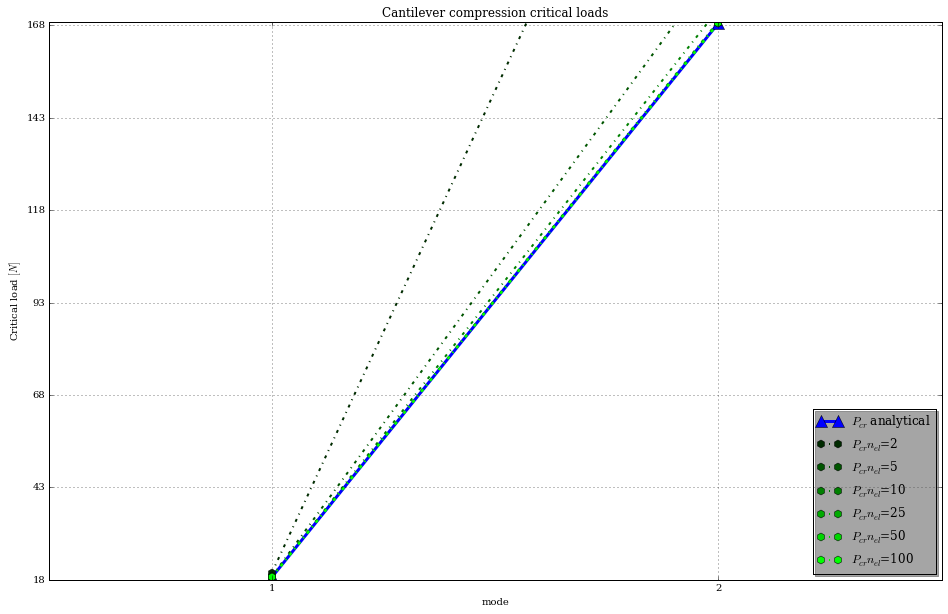

In [162]:
eig_num_plot = 2

x = np.arange(1,eig_num_plot+1)

plt.figure(figsize=(16,10), dpi=300)

plt.plot(x,Pcr[:eig_num_plot], '^-', lw=3, ms=12, label='$P_{cr}$ analytical')

print("First critical load")
print("")
print("# elem |   Pcr")
print("----------------")

for i, nel in enumerate(np.sort(list(beam_pcr.keys()))):
    plt.plot(x,beam_pcr[nel][:eig_num_plot],'h-.', lw=2, ms=8, color=(0.0,(i+1)/len(beam_pcr),0.0), \
             label="$P_{cr} n_{el}$="+str(nel)  )
    print("{0:6d} | {1:.3f}".format(nel, beam_pcr[nel][0]))

plt.xlim([0.5,eig_num_plot+0.5])
plt.ylim([np.floor(Pcr[0]),np.ceil(Pcr[eig_num_plot-1])])
plt.xticks(np.arange(1,eig_num_plot+.1))
plt.yticks(np.arange(np.floor(Pcr[0]),np.ceil(Pcr[eig_num_plot-1])+.1,25))
plt.title('Cantilever compression critical loads')
plt.xlabel(r'mode')
plt.ylabel(r'Critical load $[N]$')
plt.legend(loc='lower right', shadow=True)
plt.grid()
plt.savefig('Lab06b.jpg')

# Post-Buckling analisys

In [163]:
P_Pcr = np.array([1., 1.015, 1.063, 1.152, 1.293, 1.518, 1.884, 2.541, 4.029, 9.116])
xa_l = np.array([1., .970, .881, .741, .560, .349, .123, -0.107, -0.340, -0.577])
ya_l = np.array([0., .220, .422, .593, .719, .792, .803, .750, .625, .421])
#theta = np.arctan2(ya_l,xa_l)
#print(np.rad2deg(theta))

In [164]:
for ne in num_elems:
    write_beam_inp_file(L, h, b, ne, E, ν, 0, typ='P', inc=10000, Lpb = Pcr[0], \
                        t_data = [0.1,1.,0.01,0.1,10.0,ne+1,1,(1-ya_l[-1])*L])

## Generate Abaqus cases

In [165]:
generateCases("../Lab06b_abaqus/","b3_")

## Generate Cases with imperfection

In [166]:
for ne in num_elems:
    write_beam_inp_file(L, h, b, ne, E, ν, 0, typ='I', inc=10000, Lpb = Pcr[0], \
                        t_data = [0.5,1.,0.01,0.1,10.0,ne+1,1,(1-ya_l[-1])*L])

In [167]:
generateCases("../Lab06b_abaqus/","b4_")

## Retrieve data

In [168]:
def readDataL06b4(filename, num):
    
    file=open(filename,'r') 
    row = file.readlines()
    
    P_Pcr_l = []
    x_l = []
    y_l = []
    
    
    state = 0
    
    for line in row:
        strlist = line.split()
        if state == 0 and 'CURRENT' in strlist and 'LOAD' in strlist and 'FACTOR' in strlist:
            state = 1
            try:
                #print("load")
                #print(strlist)
                P_Pcr_l.append(float(strlist[4]))
            except ValueError:
                print(strlist)
                print("Load factor not recognized")
        if len(strlist) == 10 and state == 1:
            if strlist[0] != 'N' and strlist[0] != 'TOTAL':
                try:
                    node = int(strlist[0])
                    if node == num:
                        #print("coords")
                        #print(strlist)
                        x_l.append(float(strlist[7]))
                        y_l.append(float(strlist[9]))
                        state = 0
                except ValueError:
                    print(strlist)
                    print("Coords not recognized")
            
    file.close()
    return [np.array(P_Pcr_l), np.array(x_l), np.array(y_l)]


In [169]:
dirs = glob.glob("../Lab06b_abaqus/b4_*")

beam_pb = {}

for di in dirs:
    test = di.split('/')[-1]
    beam_pb[int(test[5:8])] = readDataL06b4(di+"/"+test+".dat",int(test[5:8])+1)

#print(beam_pb)

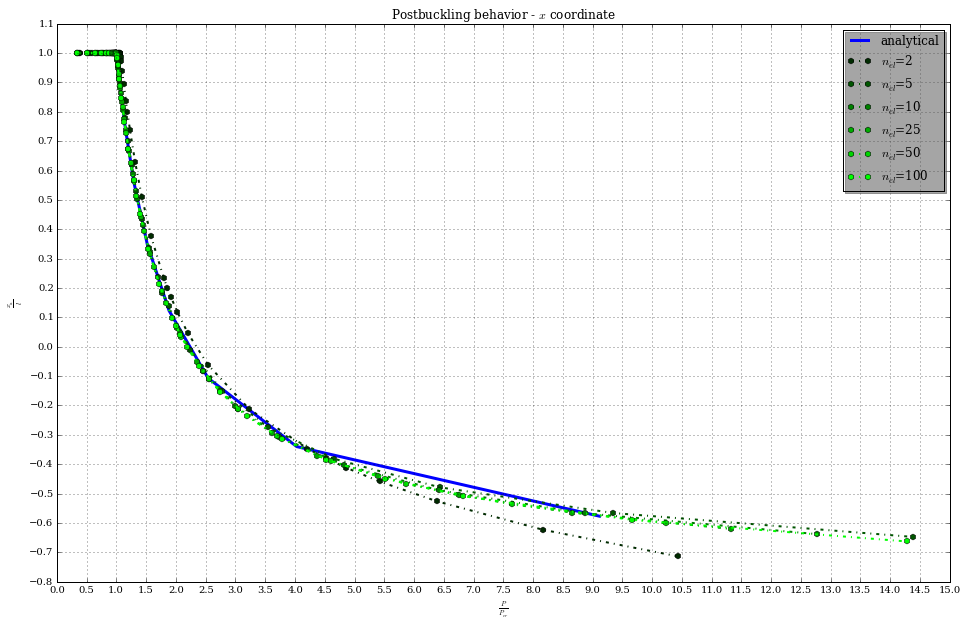

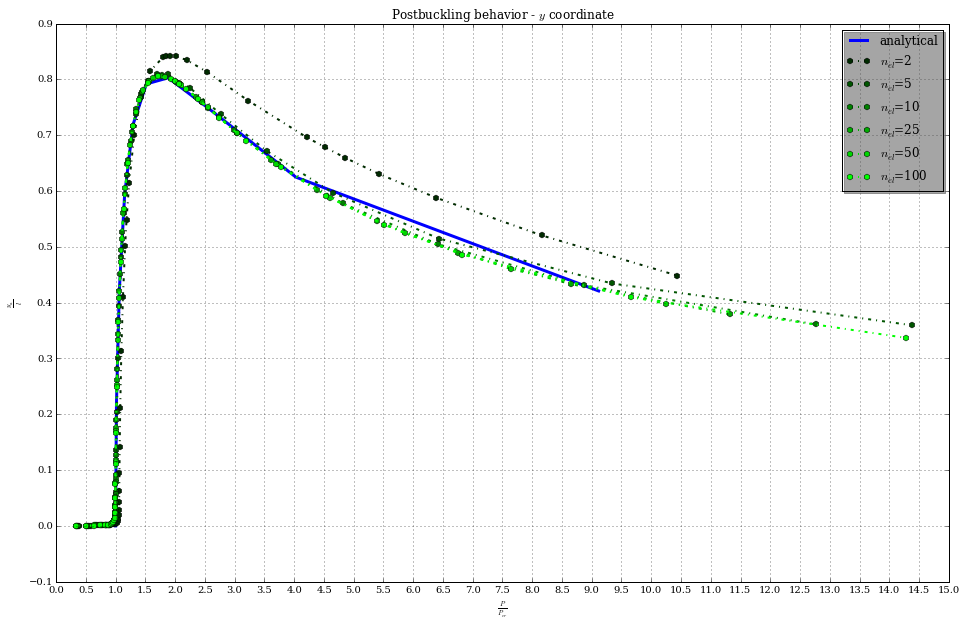

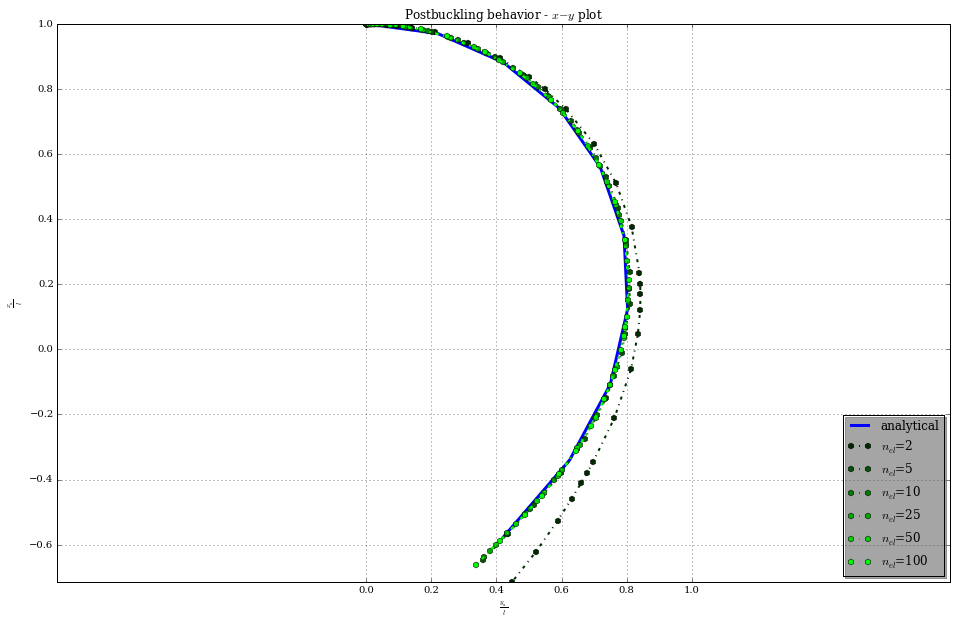

In [177]:

plt.figure(figsize=(16,10), dpi=300)
plt.plot(P_Pcr,xa_l, lw=3., label='analytical')

for i, nel in enumerate(np.sort(list(beam_pb.keys()))):
    plt.plot(beam_pb[nel][0],beam_pb[nel][1]/L,'h-.', lw=2, ms=6, color=(0.0,(i+1)/len(beam_pcr),0.0), \
             label="$n_{el}$="+str(nel)  )


plt.xlim([0,15])
plt.ylim([-0.8,1.1])
plt.xticks(np.arange(0,15+.1,0.5))
plt.yticks(np.arange(-0.8,1.2,.1))
plt.title('Postbuckling behavior - $x$ coordinate')
plt.xlabel(r'$\frac{P}{P_{cr}}$')
plt.ylabel(r'$\frac{x_a}{l}$')
plt.legend(loc='upper right', shadow=True)
plt.grid()
plt.savefig('Lab06b_x.jpg')

plt.figure(figsize=(16,10), dpi=300)

plt.plot(P_Pcr,ya_l, lw=3., label='analytical')

for i, nel in enumerate(np.sort(list(beam_pb.keys()))):
    plt.plot(beam_pb[nel][0],beam_pb[nel][2]/L,'h-.', lw=2, ms=6, color=(0.0,(i+1)/len(beam_pcr),0.0), \
             label="$n_{el}$="+str(nel)  )



plt.xlim([0,15])
plt.ylim([-.1,0.9])
plt.xticks(np.arange(0,15+.1,0.5))
plt.yticks(np.arange(-.1,1.,.1))
plt.title('Postbuckling behavior - $y$ coordinate')
plt.xlabel(r'$\frac{P}{P_{cr}}$')
plt.ylabel(r'$\frac{y_a}{l}$')
plt.legend(loc='upper right', shadow=True)
plt.grid()
plt.savefig('Lab06b_y.jpg')


plt.figure(figsize=(16,10), dpi=300)
plt.plot(ya_l,xa_l, '-', lw=3., label = 'analytical')

for i, nel in enumerate(np.sort(list(beam_pb.keys()))):
    plt.plot(beam_pb[nel][2]/L,beam_pb[nel][1]/L,'h-.', lw=2, ms=6, color=(0.0,(i+1)/len(beam_pcr),0.0), \
             label="$n_{el}$="+str(nel)  )


plt.xlim([0,1.2])
plt.ylim([-0.8,1.2])
plt.xticks(np.arange(0,1.1,0.2))
plt.yticks(np.arange(-.8,1.2,.2))
plt.title('Postbuckling behavior - $x-y$ plot')
plt.xlabel(r'$\frac{y_a}{l}$')
plt.ylabel(r'$\frac{x_a}{l}$')
plt.legend(loc='lower right', shadow=True)
plt.grid()
plt.axis('equal')

plt.savefig('Lab06b_xy.jpg')

